In [2]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [3]:
require 'paths'
require 'image'

-- relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
relative = '../Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

-- labels:apply(function(x) return x == 0 and 2 or x end)

mean = images:mean()
std = images:std()

images:add(-mean)
images:div(std)

collectgarbage()

### Render labels for displaying

In [4]:
function renderLabels(labels, img)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
            if not LUT[labels[i][j]] then
                print(labels[i][j], i, j)
            end
            for k, color in ipairs(LUT[labels[i][j]]) do
                retval[k][i][j] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = 0.62
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        retval:mul(labelsBlendCoeff)
        retval:add(img * (1 - labelsBlendCoeff))
    end
    
    return retval
end

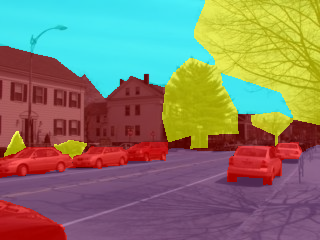

In [5]:
-- example blending
local k = 55
itorch.image(renderLabels(labels[k], images[k]))

In [6]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [7]:
require 'Integral-c-multi'

true	


In [234]:
net = nn.Sequential()

convPlusInt = nn.Concat(1)
convPlusInt:add(Integral(12, 240, 320))
convPlusInt:add(nn.SpatialConvolutionMM(3, 3*12, 3,3, 1,1, 1,1))
net:add(convPlusInt) -- 3 -> 72

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(72, 12, 1,1,1,1)) -- 72 -> 12

convPlusInt2 = nn.Concat(1)
convPlusInt2:add(Integral(8, 240, 320))
convPlusInt2:add(nn.SpatialConvolutionMM(12, 12*6, 3,3, 1,1, 1,1))
net:add(convPlusInt2) -- 12 -> 168

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(168, 8, 1,1,1,1)) -- 168 -> 8

net:add(nn.Reshape(8, 240*320))
net:add(nn.Transpose({2, 1}))

In [39]:
params, gradParams = net:getParameters()

In [14]:
net = torch.load('SB segmentation/net.t7')
losses = torch.load('SB segmentation/loss-history.t7')

In [37]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels))

In [36]:
require 'optim'

datasetIdx = 1

optimState = {
    learningRate = 0.3e-2,
    learningRateDecay = 0.99945
}

In [35]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()

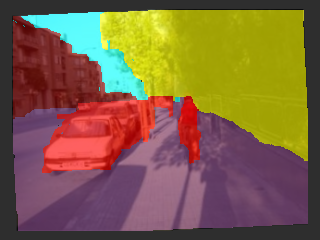

In [377]:
k =400
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [33]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(1)
    local lossesTensor = torch.Tensor(torch.load('SB segmentation/loss-history.t7'))
    gnuplot.plot(lossesTensor, '-')
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [34]:
plotLosses(losses)

In [239]:
losses = {}

In [40]:
avgLoss = 0

for iter = 1,4000 do
    windowDebugger_1:add(net:get(1):get(1))
    windowDebugger_2:add(net:get(4):get(1))

    function feval(params)
        gradParams:zero()

        local input, target = jitter(images[datasetIdx], labels[datasetIdx], torch.random() % 2 == 0)
        target = target:view(240*320)
        
        local outputs = net:forward(input)
        
        -- 
        for i = 1,target:nElement() do
            if target[i] == 0 then
                target[i] = 3
                outputs[i]:zero()
                outputs[{i,3}] = 1e4
            end
        end
        
        local loss = criterion:forward(outputs, target)

        local dLoss_dOutputs = criterion:backward(outputs, target)
        net:backward(input, dLoss_dOutputs)
        
        return loss, gradParams
    end

    local _, loss = optim.adam(feval, params, optimState)
    avgLoss = avgLoss + loss[1]
    
    collectgarbage()
    
    datasetIdx = datasetIdx % labels:size(1) + 1

    local outputFreq = 4
    if iter % outputFreq == 0 then
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
        
        plotLosses(losses)
    end
    
    local saveFreq = 50
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save('SB segmentation/net.t7', net)
        torch.save('SB segmentation/loss-history.t7', losses)
        windowDebugger_1:exportVideo('SB segmentation/int-layer-1.avi')
        windowDebugger_2:exportVideo('SB segmentation/int-layer-2.avi')
    end
    
    if iter % labels:size(1) == 0 then
        print('Epoch ' .. (iter / labels:size(1)))
    end
    
    if (iter-4) % 100 == 0 then print('Iteration ' .. iter .. ', loss = ' .. losses[#losses] or 0) end
end

Iteration 4, loss = 0.76741215586662	


Iteration 104, loss = 0.82935975492001	


Iteration 204, loss = 0.93589477241039	


Iteration 304, loss = 1.5966015905142	


Iteration 404, loss = 1.564960539341	


Iteration 504, loss = 1.2275057584047	


Iteration 604, loss = 0.72400861233473	


Iteration 704, loss = 0.93877570331097	


Epoch 1	


Iteration 804, loss = 0.87597617506981	


Iteration 904, loss = 0.71621728688478	


Iteration 1004, loss = 1.0249075293541	


Iteration 1104, loss = 0.61152341961861	


Iteration 1204, loss = 0.73507080972195	


Iteration 1304, loss = 0.81166651844978	


Iteration 1404, loss = 0.72452861070633	


Epoch 2	


Iteration 1504, loss = 0.95344094932079	


Iteration 1604, loss = 1.1512975916266	


Iteration 1704, loss = 1.2421683967113	


Iteration 1804, loss = 0.86382348835468	


Iteration 1904, loss = 0.92993193119764	


Iteration 2004, loss = 1.3326870575547	


Iteration 2104, loss = 0.7205321341753	


Epoch 3	


Iteration 2204, loss = 0.81462531536818	


Iteration 2304, loss = 1.0029206573963	


Iteration 2404, loss = 0.69562767446041	


Iteration 2504, loss = 0.71042092144489	


Iteration 2604, loss = 0.75446219742298	


Iteration 2704, loss = 0.53735642135143	


Iteration 2804, loss = 1.0744134634733	


Epoch 4	


Iteration 2904, loss = 0.66977271437645	


Iteration 3004, loss = 0.5658323019743	


Iteration 3104, loss = 1.1352748721838	


Iteration 3204, loss = 0.5987146794796	


Iteration 3304, loss = 0.96388807892799	


Iteration 3404, loss = 0.87450812757015	


Iteration 3504, loss = 0.97281062602997	


Epoch 5	


Iteration 3604, loss = 1.2145072668791	


Iteration 3704, loss = 0.51034389436245	


Iteration 3804, loss = 0.90781550109386	


Iteration 3904, loss = 0.71350103616714	


In [41]:
function predict(net, example)
    local pred = net:forward(example)
    return select(2, pred:view(240, 320, 8):max(3)):squeeze()
end

In [163]:
net = torch.load('SB segmentation/Saved v1 (0 hidden layers)/net.t7')

net:remove()
net:remove()
net:remove()

classifier = nn.Sequential()

classifier:add(nn.SpatialConvolutionMM(192, 112, 1, 1, 1, 1))
classifier:add(nn.LeakyReLU(0.01))
classifier:add(nn.SpatialConvolutionMM(112,   8, 1, 1, 1, 1))
classifier:add(nn.Reshape(8, 240*320))
classifier:add(nn.Transpose({2, 1}))

net:add(classifier)

params, gradParams = classifier:getParameters()

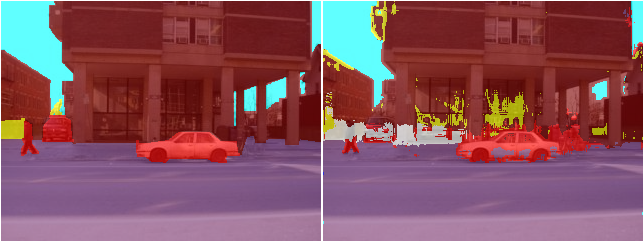

In [76]:
local k = 1
itorch.image{
    renderLabels(labels[k], images[k]),
--     renderLabels(predict(net_single, images[k]), images[k]),
    renderLabels(predict(net, images[k]), images[k])
}

In [109]:
function comparePredictions(img, labels, net, omitOriginal)
    img = img:clone()
    prediction = predict(net, img)
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2), img:size(3)*2 + 2)

        retval[{{}, {}, {1, img:size(3)}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2), img:size(3)*3 + 4)
        retval[{{}, {}, {1, img:size(3)}}]:copy(img)
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)*2+5, retval:size(3)}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [110]:
for i = 1,40 do
    local k = torch.random(715)
    image.savePNG(string.format('SB segmentation/Images/random/%03d.png', k), comparePredictions(images[k], labels[k], net))
end